# NanoSIMS Clustering
Author: Johann Maximilian Zollner, maximilian.zollner@tum.de

The following is an example of clustering NanoSIMS data with Python. This notebook shall not only demonstrate how to use various packages for microscale image analysis but also serve as an introduction, raise questions, and give food for thought for the actual hackathon.

In [1]:
import numpy as np
import pandas as pd
import tifffile
import kneed
import sklearn.decomposition
import sklearn.cluster
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage
from notebooks.scripts.clusteringentropy import clustering_entropy

Matplotlib created a temporary cache directory at /tmp/matplotlib-dsmrh_3o because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Read data

In [2]:
# choose an arbitrary ".tif" file to process
path = "/path/to/data.tif"

In [3]:
image = tifffile.imread(path)
r,c,d = image.shape
if r != c:
    image = np.transpose(image, [1,2,0])
    r,c,d = image.shape
print('Image shape: ', image.shape)

# convert to float
image = np.float32(image)

# normalize
for channel in range(d):
    image[:,:,channel] = image[:,:,channel]/np.max(image[:,:,channel])

# reshape the image to a 2D array
values = image.reshape((-1, d))
print('New shape: ', values.shape)

Image shape:  (256, 256, 7)
New shape:  (65536, 7)


## Plot

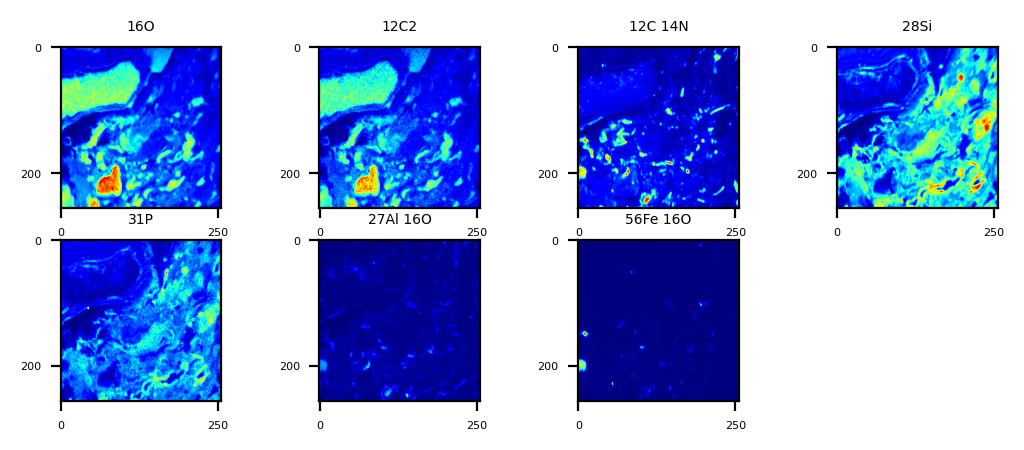

In [4]:
# visualize channels
fig = plt.figure(dpi=200)

# mass names
mass_names = ['12C' '13C' '16O' '12C 14N' '12C 15N' '27Al 16O' '56Fe 16O']

plt.set_cmap('jet')
plt.tight_layout()
for channel in range(d):
    plt.subplot(4,4,channel+1)
    plt.imshow(image[:,:,channel])
    plt.yticks(fontsize=4)
    plt.xticks(fontsize=4)
    plt.title(mass_names[channel], size=5)
# plt.colorbar(fraction=0.046, pad=0.04)

## K-Means Clustering

The scikit-learn library has various [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html#) implemented which can be applied to the data with few lines of code.
Here, we will use the K-Means algorithm to cluster the data into four groups (background, organic matter, minerals, pores).

In [5]:
# clustering with kmeans
kmeans_4c = sklearn.cluster.KMeans(n_init='auto', n_clusters=3)
kmeans_4c.fit(values)
labels_4c = kmeans_4c.predict(values)

This (or a very similar) scheme may be applied for most of the [clustering algorithms from scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#).

### Evaluation
Evaluating the clustering algorithm's performance is a non-trivial task compared to evaluating supervised methods. In the following, we present several approaches.

First, we plot the image with the computed labels.

Text(0.5, 1.0, 'K-Means with 3 Clusters')

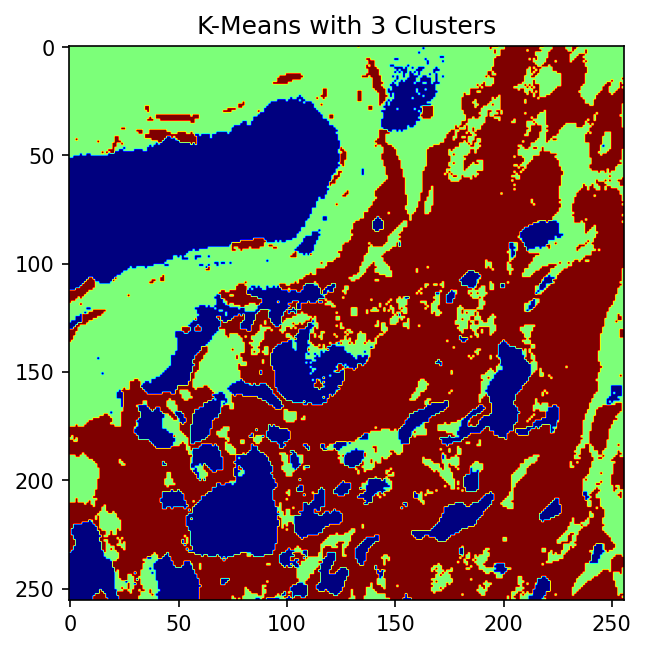

In [7]:
cluster_image_4c = labels_4c.reshape((256,256))
fig = plt.figure(dpi=150)
plt.imshow(cluster_image_4c)
plt.title('K-Means with 3 Clusters')

Another method to visualize the result is the representation as parallel coordinates. This may be done with the python package pandas.

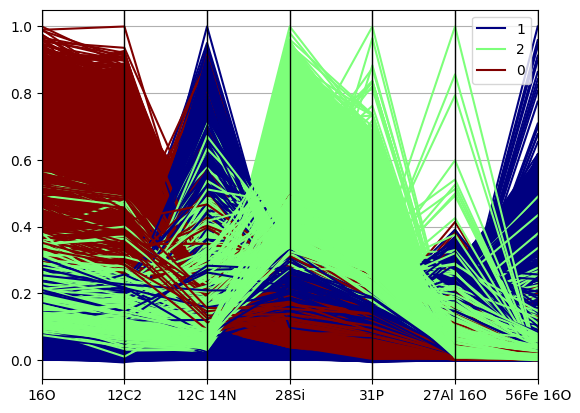

In [10]:
df = pd.DataFrame(values)
# rename columns
df = df.rename(columns={0: mass_names[0], 1: mass_names[1], 2: mass_names[2], 3: mass_names[3], 4: mass_names[4], 5: mass_names[5], 6: mass_names[6]})#,7: mass_names[7], 8: mass_names[8], 9: mass_names[9], 10: mass_names[10], 11: mass_names[11], 12: mass_names[12], 13: mass_names[13]})
df['Labels'] = labels_4c
pd.plotting.parallel_coordinates(df, 'Labels', colormap='jet');

- Organic Cluster: high carbon and high nitrogen
- Pores Cluster: high carbon and very low nitrogen
- Mineral Cluster: high oxygen, calcium, silicons, and magnesium

#### Metrics
Next, we will use four different metrics to evaluate the quality of our clusters:

1. Silhouette Coefficient: a **higher** score relates to a model with better defined clusters.
2. Calinski-Harabasz Index: a **higher** score relates to a model with better defined clusters.
3. Davies-Bouldin Index: a **lower** score relates to a model with better defined clusters.

You can read more on clustering performance evaluation and the implemented metrics in scikit-learn [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

4. The entropy of the cluster: measures the amount of disorder in the data. The larger the disorder, the larger the entropy value. The smallest possible value is 0, which appears then all vector elements are the same.

You can find the implementation for the clustering entropy in the "/scripts" directory.

In [11]:
def compute_scores(values, labels):
    #silhouette = sklearn.metrics.silhouette_score(values, labels, metric='euclidean')
    calinski_harabasz = sklearn.metrics.calinski_harabasz_score(values, labels)
    davies_bouldin = sklearn.metrics.davies_bouldin_score(values, labels)

    return {#'Silhouette Coefficient': silhouette,
            'Calinski-Harabasz Index': calinski_harabasz,
            'Davies-Bouldin Index': davies_bouldin}

In [12]:
scores_4c = compute_scores(values, labels_4c)
scores_4c.update({'Entropy': clustering_entropy(np.reshape(values, image.shape), labels_4c)})

print('Scores for Kmeans with 4 Clusters:\n', scores_4c)

Scores for Kmeans with 4 Clusters:
 {'Calinski-Harabasz Index': 47177.59315314233, 'Davies-Bouldin Index': 0.991877352317318, 'Entropy': 2.853491072792081}


## K-means with dimensionality reduced data
Dimensionality reduction can not create more suitable features for our algorithm, it also enables us to visualize our clusters. Here, we use principle component analysis to increase the interpretability of the data while preserving the maximum amount of information.

In [13]:
# dimensional reduction with PCA
components=2
pca =sklearn.decomposition.PCA(n_components=components)
pca.fit(values)
image_pca = pca.transform(values)

# clustering with kmeans
kmeans_pca_4c = sklearn.cluster.KMeans(n_init='auto', n_clusters=3)
kmeans_pca_4c.fit(image_pca)
labels_pca_4c = kmeans_pca_4c.predict(image_pca)

### Evaluation

Text(0.5, 1.0, 'K-Means with PCA')

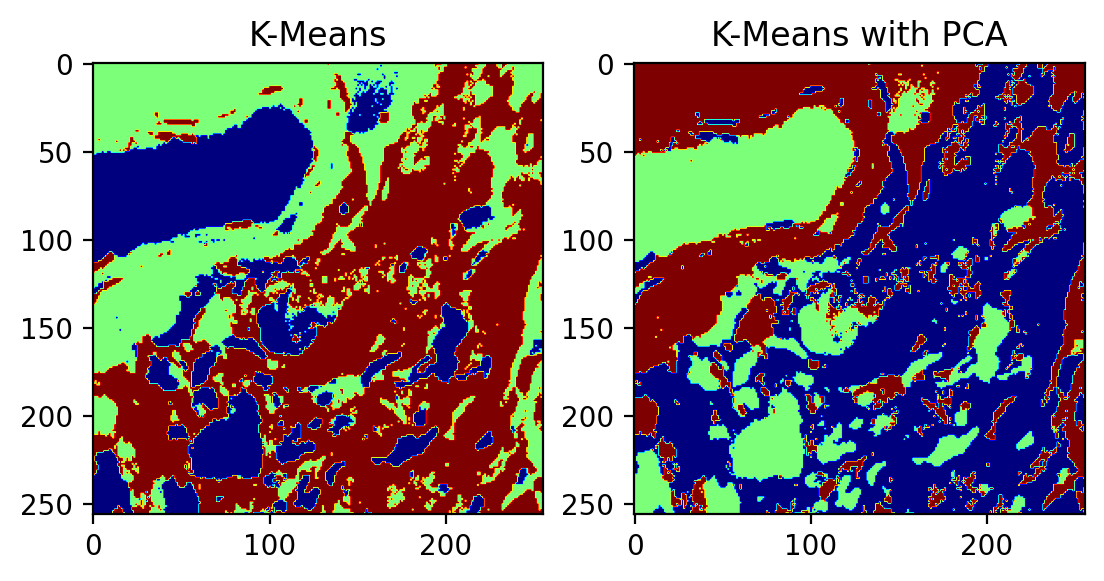

In [14]:
# visualize result
cluster_image_pca_4c = labels_pca_4c.reshape((256,256))
fig = plt.figure(dpi=200)
plt.tight_layout()

plt.subplot(1,2,1)
plt.imshow(cluster_image_4c)
plt.title('K-Means')

plt.subplot(1,2,2)
plt.imshow(cluster_image_pca_4c)
# im_ratio = cluster_image_1.shape[0]/cluster_image_1.shape[1]
# plt.colorbar(fraction=0.047*im_ratio, ticks=[0,1,2,3])
plt.title('K-Means with PCA')

While plotting the results in parallel coordinates is not suitable anymore with the dimensionality-reduced data, other possibilities open up. 
A way to think about the k-means model is that it places a circle at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius is a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a cluster member.
We may now visualize the clusters and related circles in a scatter plot.
Therefore, the following function is given.

In [16]:
def plot_kmeans(kmeans, labels, X, n_clusters=4, rseed=0, ax=None):
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

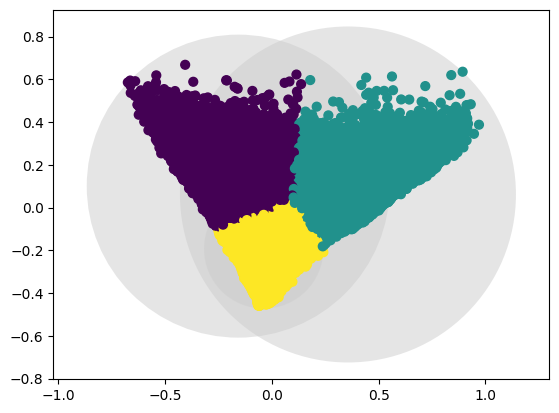

In [17]:
plot_kmeans(kmeans_pca_4c, labels_pca_4c, image_pca)

Furthermore, we may again compute our scores.

In [15]:
scores_pca_4c = compute_scores(image_pca, labels_pca_4c)
scores_pca_4c.update({'Entropy': clustering_entropy(np.reshape(image_pca, (image.shape[0],image.shape[1],components)), labels_pca_4c)})

print('Scores for Kmeans with 4 Clusters:\n', scores_4c)
print('Scores for Kmeans with PCA and 4 Clusters:\n', scores_pca_4c)

Scores for Kmeans with 4 Clusters:
 {'Calinski-Harabasz Index': 47177.59315314233, 'Davies-Bouldin Index': 0.991877352317318, 'Entropy': 2.853491072792081}
Scores for Kmeans with PCA and 4 Clusters:
 {'Calinski-Harabasz Index': 72362.13523104513, 'Davies-Bouldin Index': 0.7630292767648851, 'Entropy': 0.8303257853551906}


## Minimizing/Maximizing a Score
Next, an approach for improving the clustering performance is the minimization or maximization of some score referring to the clustering quality. Here, we use the entropy of the cluster but you could also use any of the other scores we have computed above.

In [18]:
entropies = []
for i in tqdm(range(2,32)):
    kmeans = sklearn.cluster.KMeans(n_init='auto', n_clusters=i)
    kmeans.fit(image_pca)
    labels = kmeans.predict(image_pca)
    entropies.append(clustering_entropy(np.reshape(image_pca, (image.shape[0],image.shape[1],components)), labels))

100%|████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.37it/s]


Text(0, 0.5, 'Entropy')

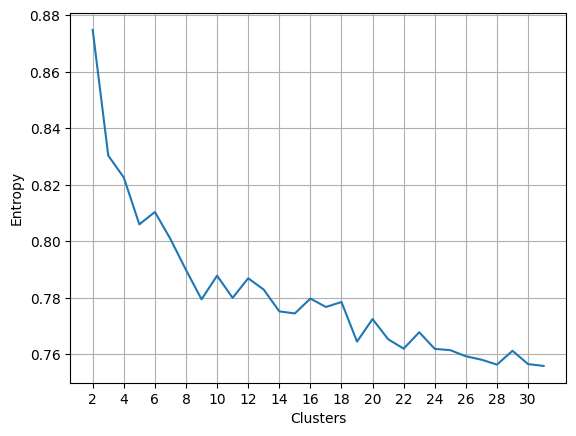

In [19]:
fig = plt.figure(dpi=100)
plt.plot(range(2,32), entropies)
plt.grid()
plt.xticks(np.arange(2, 32, 2));
plt.xlabel('Clusters')
plt.ylabel('Entropy')

There is a handy tool called [kneed](https://github.com/arvkevi/kneed) to detect the point of maximum curvature. However, we must be careful since kneed assumes convex/concave functions, which is not guaranteed in our case.

In [20]:
kn = kneed.KneeLocator(range(2,32), entropies, curve='convex', direction='decreasing', interp_method='polynomial')
print("Kneed: Point of maximum curvature at: ", kn.knee)
n_clusters = kn.knee

Kneed: Point of maximum curvature at:  7


In [26]:
n_clusters = 5

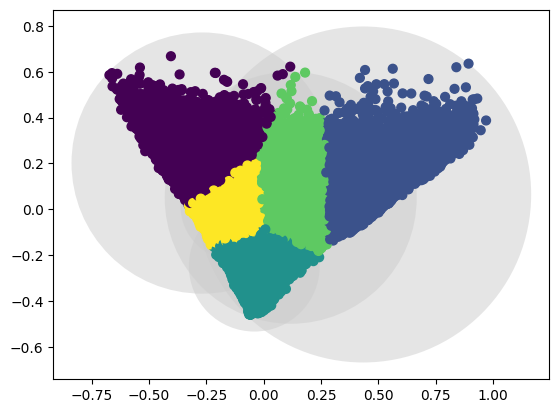

In [27]:
# clustering with kmeans
kmeans_min_entropy = sklearn.cluster.KMeans(n_init='auto', n_clusters=n_clusters)
kmeans_min_entropy.fit(image_pca)
labels_min_entropy = kmeans_min_entropy.predict(image_pca)

# visualize clusters
plot_kmeans(kmeans_min_entropy, labels_min_entropy, image_pca)

Text(0.5, 1.0, 'K-Means with PCA and 5 Clusters')

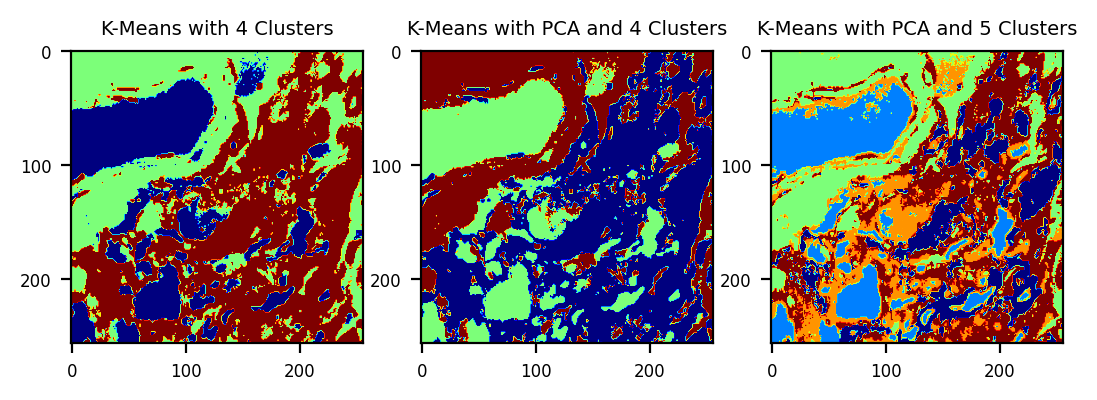

In [30]:
# visualize result
cluster_image_pca_min_entropy = labels_min_entropy.reshape((256,256))
fig = plt.figure(dpi=200)
plt.subplots_adjust(top=2)

plt.subplot(1,3,1)
plt.imshow(cluster_image_4c)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('K-Means with 4 Clusters', size=7)

plt.subplot(1,3,2)
plt.imshow(cluster_image_pca_4c)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('K-Means with PCA and 4 Clusters', size=7)

plt.subplot(1,3,3)
plt.imshow(cluster_image_pca_min_entropy)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title(f'K-Means with PCA and {n_clusters} Clusters', size=7)

However, now we have to find a way to regroup the clusters, like for example, in "Unsupervised Methods for OCNN".

Finally, we again compute our scores.

In [29]:
scores_pca_min_entropy = compute_scores(image_pca, labels_min_entropy)
scores_pca_min_entropy.update({'Entropy': clustering_entropy(np.reshape(image_pca, (image.shape[0],image.shape[1],components)), labels_min_entropy)})

print('Scores for Kmeans with 4 Clusters:\n', scores_4c)
print('Scores for Kmeans with PCA and 4 Clusters:\n', scores_pca_4c)
print(f'Scores for Kmeans with PCA and {n_clusters} Clusters:\n', scores_pca_min_entropy)

Scores for Kmeans with 4 Clusters:
 {'Calinski-Harabasz Index': 47177.59315314233, 'Davies-Bouldin Index': 0.991877352317318, 'Entropy': 2.853491072792081}
Scores for Kmeans with PCA and 4 Clusters:
 {'Calinski-Harabasz Index': 72362.13523104513, 'Davies-Bouldin Index': 0.7630292767648851, 'Entropy': 0.8303257853551906}
Scores for Kmeans with PCA and 5 Clusters:
 {'Calinski-Harabasz Index': 68361.02607715108, 'Davies-Bouldin Index': 0.8371374116940025, 'Entropy': 0.8053573789903669}


## Note
Hierarchical clustering, like it is shown in "unsupervised_methods_for_OCCN" is also possible with a few lines of code in Python. Check the scipy implementations [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html), [dendogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html), and scikit-learn's [agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) for more information. However, note that the **computation takes up to 10 minutes** and can only be done with the group notebooks due to the memory requirements.